# 熱伝導方程式の数値解法
## 第一講:陽解法
# 一次元熱伝導方程式

本講義では熱伝導方程式を数値計算していきます。  
コーディングは今回、Juliaで行います。 （シンプルにpythonの忘れがひどい）  
基本的なところは波動方程式の解法と同じですので、そちらも参考にしてください。  

In [1]:
versioninfo()

Julia Version 1.5.0
Commit 96786e22cc (2020-08-01 23:44 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i9-10900 CPU @ 2.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


熱伝導方程式  
\begin{align*}
& \frac{\partial U}{\partial t}=\frac{K_0}{cρ} (\frac{\partial^2 U}{\partial x^2}+\frac{\partial^2 U}{\partial y^2})
\end{align*}


熱伝導方程式の基本式はこんな感じです。
波動方程式と比較すると、時間項が一階微分になっています。

波動方程式  
\begin{align*}
& \frac{\partial^2 u}{\partial t^2}=c^2 (\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2})
\end{align*}


時間項が一階であるので、  
座標の方の差分を過去方向にとるか、未来方向にとるか、  
によって解放が異なります。  

まずは両方の場合について、離散化してみます。  
簡単のため、一次元にします。  
\begin{align*}
& \frac{\partial U}{\partial t}=\frac{K_0}{cρ} (\frac{\partial^2 U}{\partial x^2})
\end{align*}

波動方程式の時と同じように離散化します。  
さらに、  
時間項 t{1 : n}  
1からnまで変化  
位置項 x{1 : i}  
1からiまで変化  
とします。

ここでの、n,iは座標の通し番号であり、実際の長さを意味しません。  



離散化の詳しい方法は波動方程式の離散化の項を見てください。  
陽解法と陰解法のそれぞれの離散化後の数式を見てみましょう。  
### 陽解法(前進オイラー法)

\begin{align*}
& \frac{U^{n+1}_i - U^{n}_i}{\Delta t}=\frac{K_0}{cρ} (\frac{U^n_{i+1} - 2U^n_{i}+U^n_{i-1}}{\Delta x^2})\tag{1}
\end{align*}
### 陰解法(後退オイラー法)

\begin{align*}
& \frac{U^{n+1}_i - U^{n}_i}{\Delta t}=\frac{K_0}{cρ} (\frac{U^{n+1}_{i+1} - 2U^{n+1}_{i}+U^{n+1}_{i-1}}{\Delta x^2})\tag{2}
\end{align*}
さて、ここで違うことは右辺の時間座標の位置が、n+1 か、nか、ということです。  
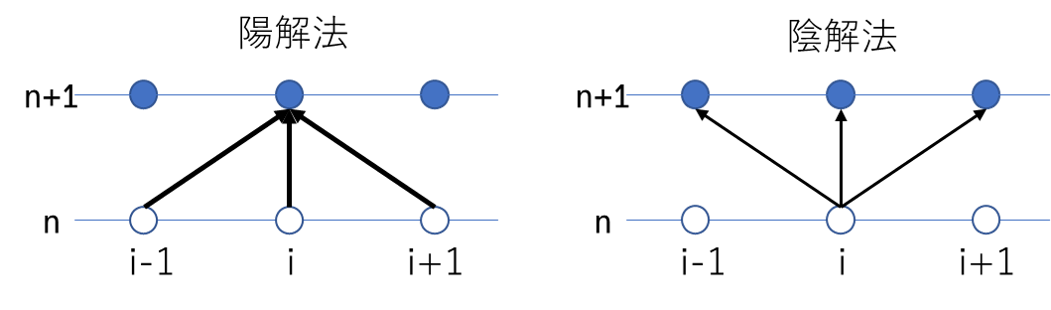

n は現在時刻なので、既知です。  
**陽解法**は既知の3点から1点を求める、未定変数一つの方程式ですので、解くことが可能です。  
一方、**陰解法**の場合は、  
既知の1点から未定変数3点を求めるので、解くことができません。  
しかし、i = 1から 順に考えると、
```
i = 0, 1, 2
i =    1, 2, 3  
i =       2, 3, 4
i =          3, 4, 5
```
となるので、全部並べれば、一番端の点を(境界条件で)決めてしまえば、  
未定変数はi個の連立i次方程式となりますので、
後は順繰りに解くことができます。  


そんなめんどくさいことしなくても、陽解法使っとけばええやんけと思われるかもしれませんが、  
陽解法は不安定条件が存在します。  
Δｘを小さくとりすぎると発散してしまうので、一般には使えません。

が、まずは陽解法をやります。


# 条件
$\frac{K_0}{cρ}$ は 熱拡散率と呼ばれるパラメータです。  
k ：熱伝導率（Js-1m-1K-1）  
ρ：密度（kg m-3）  
c：比熱容量（J kg-1K-1）  
単位は$m^2/s$となります。(文献によってmm2 になってたりするので気を付けましょう。)  
  
まずは、まぁ適当な題材で鉄を選びます。  
$ 22.8 *10^{-6} m^2/s $
だそうです。  

不安定条件に付いての話はあとでするとして、
まずは以下のようにパラメータを取ります。  
$ \Delta x = 0.0001 m $  
$ \Delta t = 0.0001 s $  

鉄の長さは5mm  (=0.05m)  
時間は0.5秒

♯初期条件と境界条件
波動方程式のところでもやりましたが、  
時間nを1から解くとすると、  {1}式で、n-1のところ、0番目がでてきてしまい、  
解けません。

ですので、改めて時間n=0の条件は固定しなければなりません。  
これが**初期条件** です。

同様に、座標i を1から解くとすると {1}式では、i-1,
また、座標i がiの時、i+1が出てきてしまうので、両端の条件は決めなければなりません。  
これが**境界条件**です。

初期条件は左端を500 度にしましょう  
そしてこの温度は固定にしましょう。常に500度で熱し続ける感じです。  
右端の境界条件は空気を想定して25度です。  


改めて、陽解法の離散化数式を確認します  

\begin{align*}
& \frac{U^{n+1}_i - U^{n}_i}{\Delta t}=\frac{K_0}{cρ} (\frac{U^n_{i+1} - 2U^n_{i}+U^n_{i-1}}{\Delta x^2})\tag{1}
\end{align*}

左辺に未知項、右辺に既知項をまとめると  



\begin{align*}
& U^{n+1}_i = U^{n}_i + \frac{\Delta t K_0}{cρ} (\frac{U^n_{i+1} - 2U^n_{i}+U^n_{i-1}}{\Delta x^2})\tag{3}
\end{align*}


\begin{align*}
& U^{n+1}_i = (1-2\frac{\Delta t K_0}{cρ\Delta x^2})U^{n}_i + \frac{\Delta t K_0}{cρ} (\frac{U^n_{i+1}+U^n_{i-1}}{\Delta x^2})\tag{4}
\end{align*}

# コーディング
では早速コーディングです。
以下のようにします。

In [2]:
function K(T)
    #入力する温度はケルビンなので、
    #摂氏を入れたらケルビンにする関数を作る
    return Float64(T + 273)
end

K (generic function with 1 method)

何となくですけど、摂氏で入力したくなるので、ケルビン変換を作っておきます。  
※少し詳しくなると、引数の型指定はしなくていいのか？と思います。  
これはほかの言語を触っている人ならなおさらかも知れません。  

juliaの場合、多重ディスパッチという機能によって
引数の型によって関数の挙動を変えることができます。  
逆に言えば、引数の型をしてしないことによって、  
すべての変数をFloat64()にかけて、出てくる数値がFloat64にかけるような関数にしました。  

In [3]:
function Calcmain(L,T,Tc,Δx,Δt)

    Nx = Int(round(L/Δx))
    Nt = Int(round(T/Δt))
    @show Nt,Nx
    #摂氏入力
    init_temp = K(500)
    boundary_temp_right = K(25)
    boundary_temp_left = K(500)
    room_temp = K(25)
    @show init_temp, boundary_temp_left,  boundary_temp_right

    result = fill(room_temp, (Nt,Nx))
    # initial set
    result[1,1] =init_temp

    λ = (Δt/Δx^2)*Tc
    # 計算
    for n in 1: Nt -1
        for i in 1:Nx
            if i == 1
                result[n+1,i] = (1-2*λ)*result[n,i] + λ*(boundary_temp_left + result[n,i+1])
            elseif i == Nx
                result[n+1,i] = (1-2*λ)*result[n,i] + λ*(result[n,i-1] + boundary_temp_right)
            else
                result[n+1,i] = (1-2*λ)*result[n,i] + λ*(result[n,i-1] + result[n,i+1])
            end
        end
        #
    end

    return result

end

Calcmain (generic function with 1 method)

**3,4行目**  
Nx、Nt のところ、丸目誤差のせいで、L/Δx は 整数になりません。 よってrange に使えないので、int(round())とります  
**11行目**  
resultのところ、最初は常温にしておきます。  
fill関数ですべての値を一定の値にできます。  

**13行目**  
初期条件を入れておきましょう
  
**15行目**  
係数はλにしておきます。
  
**17-28行目**  
i=1,Nx のときは境界条件を使って計算します。  

In [4]:
L = 0.005 #長さ
T = 0.5 #時間範囲
Tc = 22.8*10^-6 # 鉄の熱拡散定数

Δx = 0.0001
Δt = 0.0001
# 0.1ms。ここまで大げさに切ってるのは、陽解法の安定条件に入れたかったから

Nx = Int(round(L/Δx))
Nt = Int(round(T/Δt))

@time result = Calcmain(L, T, Tc, Δx, Δt)

(Nt, Nx) = (5000, 50)
(init_temp, boundary_temp_left, boundary_temp_right) = (773.0, 773.0, 773.0)
  0.087669 seconds (260.67 k allocations: 15.968 MiB, 9.87% gc time)


5000×50 Array{Float64,2}:
 773.0    298.0    298.0    298.0    …  298.0    298.0    298.0    298.0
 664.7    406.3    298.0    298.0       298.0    298.0    298.0    406.3
 630.477  440.523  322.692  298.0       298.0    298.0    322.692  465.215
 619.663  456.967  343.928  303.63      298.0    303.63   349.558  502.895
 617.529  468.289  360.513  311.534     299.284  312.818  374.047  529.518
 618.95   477.743  373.919  319.908  …  302.077  323.692  395.534  549.585
 621.878  486.266  385.276  328.09      306.142  335.144  414.278  565.4
 625.414  494.16   395.263  335.892     311.146  346.574  430.691  578.277
 629.138  501.537  404.275  343.29      316.788  357.675  445.162  589.024
 632.845  508.454  412.546  350.312     322.831  368.3    458.016  598.17
 636.44   514.949  420.224  356.998  …  329.096  378.388  469.516  606.076
 639.875  521.051  427.406  363.38      335.458  387.927  479.874  612.999
 643.136  526.792  434.159  369.49      341.824  396.928  489.263  619.127
   ⋮  

計算結果が表示されていると思います。  
Nt,Nxの行列にしているので、  
行方向が時間、列方向が距離です。  

Jupyterを入れている人は6行目、  
Δtの時間を大きくしていってみてください。  
0.0001(0.1ms)ですが、0.001に変えてみましょう。  

どうですか？  
0.0001は問題ないと思いますが、0.001の時に数値がおかしくなると思います。   
陽解法には**不安定条件**があり、  
Δtを大げさに小さくとる必要があります。  
なんでかっていうのは、まぁ本読んで勉強してください。  

具体的には、λ≦1/2の時安定です。  
安定性確認の関数とグラフをつくってみましょう。

Δxの方を0.0001に固定し、Δtの方を変えてみます。

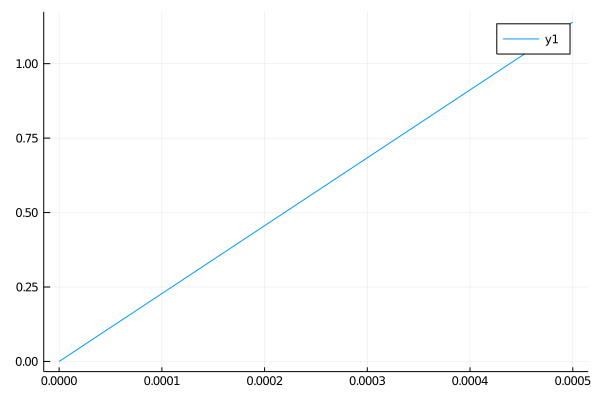

In [5]:
cλ(t) = (t/Δx^2)*Tc

using Plots
gr()

t = range(0,0.0005,step = 0.0001)
plot(t, cλ(t))

これをみると、0.0002と0.0003の間で0.5 を超えてそうです。  
[4] のコードに実際に0.0002と0.0003を入れてみましょう。  
前者は安定に数値が出ていますが、後者は発散します。  
  
この値はΔxの値を変えれば変化します。  
要はΔｘを細かくとればとるほど、Δtを細かくとる必要があり、  
計算に時間がかかります。  
また一次元ならともかく、複数次元だとすべてのデータを保持する必要があり、  
メモリ容量もかなり必要です。  


┌ Info: Saved animation to 
│   fn = C:\Users\KTOYODA\OneDrive\Programming\Lecture\Julialecture_forlab\陽解法.gif
└ @ Plots C:\Users\KTOYODA\.julia\packages\Plots\ey5o3\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\KTOYODA\\OneDrive\\Programming\\Lecture\\Julialecture_forlab\\陽解法.gif")
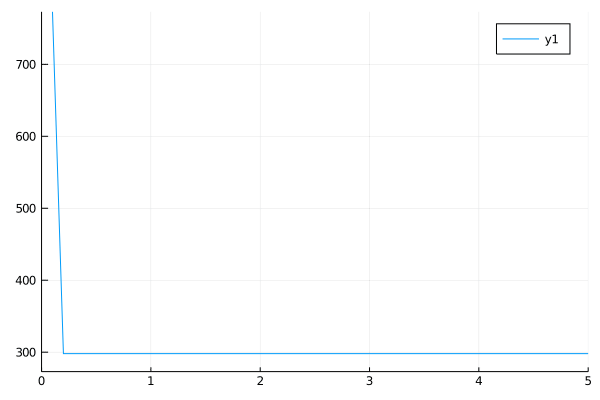

In [6]:
anim = @animate for n in range(1, Nt, step = 10)
    plot(range(Δx*1000,L*1000,length = Nx), view(result,n,:),
    ylims = (273,773),
    xlims = (0,5))
end

 gif(anim, "陽解法.gif", fps=60)


後は計算結果をアニメーションにしてみましょう。
横軸は㎜単位に換算しました。  

500度で熱し続けた場合、  
安定になるのに大体0.5秒ぐらいかかりますね。  
右端は25度固定なので、最終的には直線になります。  

もし、右端も最終的に500度になるような系を作りたいなら、  
ディリクレじゃなくてノイマンにする必要があります。  

でもまぁ今日はこんなところです。  
わからないところがあったら教えてください。  
いつでもアップデートします。  

**Caclmainを書き換えて、ノイマン条件にしてみましょう。**

In [7]:
function Calcmain_neuman(L,T,Tc,Δx,Δt)

    Nx = Int(round(L/Δx))
    Nt = Int(round(T/Δt))
    @show Nt,Nx
    #摂氏入力
    init_temp = K(500)
    boundary_temp_right = K(25)
    boundary_temp_left = K(500)
    room_temp = K(25)
    @show init_temp, boundary_temp_left,  boundary_temp_right

    result = fill(room_temp, (Nt,Nx))
    # initial set
    result[1,1] =init_temp

    λ = (Δt/Δx^2)*Tc
    # 計算
    for n in 1: Nt -1
        for i in 1:Nx
            if i == 1
                result[n+1,i] = (1-2*λ)*result[n,i] + λ*(boundary_temp_left + result[n,i+1])
            elseif i == Nx
                result[n+1,i] = (1-2*λ)*result[n,i] + λ*(result[n,i-1] + result[n,i-1])
            else
                result[n+1,i] = (1-2*λ)*result[n,i] + λ*(result[n,i-1] + result[n,i+1])
            end
        end
        #
    end

    return result

end

Calcmain_neuman (generic function with 1 method)

24行目を書き換えました。

In [8]:
L = 0.005 #長さ
T = 0.5 #時間範囲
Tc = 22.8*10^-6 # 鉄の熱拡散定数

Δx = 0.0001
Δt = 0.0001
# 0.1ms。ここまで大げさに切ってるのは、陽解法の安定条件に入れたかったから

Nx = Int(round(L/Δx))
Nt = Int(round(T/Δt))

@time result = Calcmain_neuman(L, T, Tc, Δx, Δt)

(Nt, Nx) = (5000, 50)
(init_temp, boundary_temp_left, boundary_temp_right) = (773.0, 773.0, 298.0)
  0.045394 seconds (142.82 k allocations: 9.772 MiB, 17.60% gc time)


5000×50 Array{Float64,2}:
 773.0    298.0    298.0    298.0    …  298.0    298.0    298.0    298.0
 664.7    406.3    298.0    298.0       298.0    298.0    298.0    298.0
 630.477  440.523  322.692  298.0       298.0    298.0    298.0    298.0
 619.663  456.967  343.928  303.63      298.0    298.0    298.0    298.0
 617.529  468.289  360.513  311.534     298.0    298.0    298.0    298.0
 618.95   477.743  373.919  319.908  …  298.0    298.0    298.0    298.0
 621.878  486.266  385.276  328.09      298.0    298.0    298.0    298.0
 625.414  494.16   395.263  335.892     298.0    298.0    298.0    298.0
 629.138  501.537  404.275  343.29      298.0    298.0    298.0    298.0
 632.845  508.454  412.546  350.312     298.0    298.0    298.0    298.0
 636.44   514.949  420.224  356.998  …  298.0    298.0    298.0    298.0
 639.875  521.051  427.406  363.38      298.0    298.0    298.0    298.0
 643.136  526.792  434.159  369.49      298.0    298.0    298.0    298.0
   ⋮                     

┌ Info: Saved animation to 
│   fn = C:\Users\KTOYODA\OneDrive\Programming\Lecture\Julialecture_forlab\陽解法2.gif
└ @ Plots C:\Users\KTOYODA\.julia\packages\Plots\ey5o3\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\KTOYODA\\OneDrive\\Programming\\Lecture\\Julialecture_forlab\\陽解法2.gif")
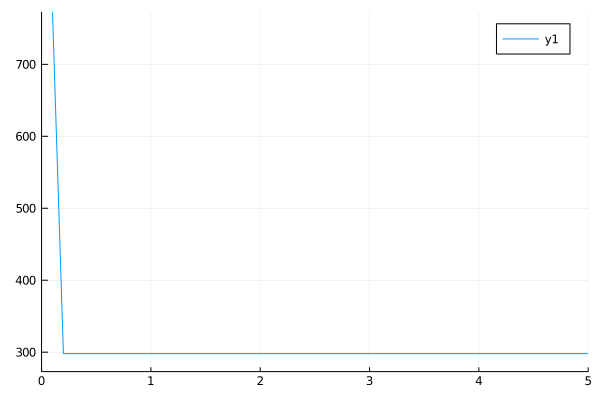

In [9]:
anim = @animate for n in range(1, Nt, step = 10)
    plot(range(Δx*1000,L*1000,length = Nx), view(result,n,:),
    ylims = (273,773),
    xlims = (0,5))
end

 gif(anim, "陽解法2.gif", fps=60)

左側を500度の定温条件。  
右側をノイマン条件(断熱条件）にしてみました。  
現実に合った感じになったかな？  
  
こんなところです。